# Ocean-Atmosphere CO<sub>2</sub> Fluxes

## Goal: Predict global ocean-atmosphere CO<sub>2</sub> flux
The flux of carbon between the ocean and atmosphere depends on complex biogeochemical ocean processes which are difficult to measure. You will attempt to predict this flux from readily-available physical ocean and atmosphere observations. 

## Introduction
The oceans have absorbed around 1/3 of all the CO<sub>2</sub> we have released into the atmosphere.
The exchange of CO<sub>2</sub> between the atmosphere and oceans depends primarily on the concentration gradient between the surface ocean and atmosphere.
The atmosphere is relatively well-mixed compared to the ocean, so the main driver of the ocean-atmosphere CO<sub>2</sub> gradient is surface ocean variability.
The concentration of CO<sub>2</sub> in the result of complex interactions between physical and biological parameters, and is difficult to predict with models.
Ocean CO<sub>2</sub> must be measured by in-situ water sampling and titration methods, which are both temporally and spatially patchy.

<img src="https://www.socat.info/wp-content/uploads/2019/06/socatv2019_map.png" width="800em">
<div style="text-align: center">Locations of moorings and tracks of ships and drifters for all data in SOCAT version 2019 (1970-2019).</div>

Monitoring of air-sea CO<sub>2</sub> exchange in a meaningful way requires spatially and temporally continuous information, and substantial effort has been invested in interpolating these point-measurements of CO<sub>2</sub> onto more readily-available gridded datasets.
In this exercise, we will explore the ability of models to predict air-sea CO<sub>2</sub> fluxes using on biological and physical parameters that can be measured by remote sensing.

## Predictors
The standard set of variables known to represent the *physical* and *biogeochemical* drivers of surface ocean pCO2 are sea surface salinity (SSS), sea surface temperature (SST), mixed layer depth (MLD), chlorophyll-a concentration (CHL), sea surface height (SSH) and the atmospheric CO_2 mole fraction ($xCO_{2-atm}$) (Takahashi et al., 2009; Land- schützer et al., 2013).

### Training Data
Gridded fCO<sub>2</sub> data from the SOCAT programme are combined with remote sensing data to provide the training set including data from January, February and March from 2001 onwards.
 * Monthly global reprocessed products of physical variables from ARMOR3D L4 distributed through the Copernicus Marine Environment Monitoring Service (CMEMS; 0.25◦ × 0.25◦; http://marine.copernicus.eu/services-portfolio/access-to-products/?option=com_csw&view=details&product_id=MULTIOBS_GLO_PHY_REP_015_002, last access: 27 October 2017) are used for SSS, SST and SSH (Guinehut et al., 2012). 
 * The GlobColour project provides monthly chlorophyll (GlobColour “CHL” data) distributions at a 1◦ × 1◦ resolution (http://www.globcolour.info/products_description.html,
last access: 31 October 2017). 
 * For MLD, daily data from the “Estimating the Circulation and Climate of the Ocean” (ECCO2) project Phase II (Cube 92), at a 0.25◦ × 0.25◦ resolution (Menemenlis et al., 2008) are used. 
 * For atmospheric xCO_2, the 6h data from Jena CO2 inversion s76_v4.1 on a 5◦ × 5◦ grid are selected (http://www.bgc-jena.mpg.de/CarboScope/?ID=s, last access: 13 September 2017). 
 * Finally, an ice mask based on daily “Operational Sea Surface Temperature and Sea Ice Analysis” (OSTIA) data with a gridded 0.05◦×0.05◦ resolution (Donlon et al., 2011) is applied.

#### Training Data Distribution
Note that we're working with a subset of the SOCAT database including only Jan-March. This means that our data is considerably more sparse than the SOCAT map above, complicating the application of objective interpolation techniques:

<img src="figs/stationmap.png" width="800em">



### Gridded Target Data
For testing, we provide gridded predictors for Feb 2019. The goal is to estimate the ocean-atmosphere CO<sub>2</sub> for this month.
- Physical parameters (SST, SSS, MLD, SSH) are sourced from the [Copernicus Marine Environment Monitoring Service (CMEMS)](https://marine.copernicus.eu/). Specifically, the ARMOR3D L4 product on a 0.25<sup>o</sup> grid.
- CHL, a proxy for phytoplankton abundance and biological productivity, is sourced from the [ESA Ocean Colour](https://climate.esa.int/en/projects/ocean-colour/data/) programme.
- xCO2 is taken from the [Jena CO2 inversion](http://www.bgc-jena.mpg.de/CarboScope/?ID=s) (version s10oc_v2020).
- Surface Wind Speed from CERSAT ([CERSAT-GLO-REP_WIND_L4_](https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=WIND_GLO_PHY_CLIMATE_L4_REP_012_003)).

All testing data have been linearly interpolated onto a 1<sup>o</sup> grid.

### Model Target

$$
\Delta CO_2 = f\left(SST, SSS, SSH, MLD, CHL, xCO2, Lat, Lon, Year \right)
$$

Think carefully about how best to normalise the data for regression.

## Load Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

# some helper functions in the 'helpers' folder.
from helpers import calc, plot

In [2]:
# load training data
data = pd.read_csv('data/X_train_trimmed.csv')

In [3]:
data.head()

,year,SSS,SST,SSH,CHL,MLD,xCO2,lat,lon,fCO2,DeltaCO2
0,2001.0,33.824438,-0.812313,-1.297375,0.395534,15.281344,367.386291,-66.5,142.5,319.571930,-47.814361
1,2001.0,33.793714,-0.825357,-1.278312,0.365394,15.439311,367.369910,-66.5,143.5,313.183136,-54.186774
2,2001.0,33.800500,-0.956571,-1.255688,0.332476,16.350091,367.356882,-66.5,144.5,307.872162,-59.484720
3,2001.0,33.805937,-0.947063,-1.252312,0.311651,16.354686,367.357386,-66.5,145.5,303.776093,-63.581293
4,2001.0,33.813375,-0.770188,-1.246063,0.368403,18.278711,367.348208,-66.5,146.5,289.001007,-78.347201


In [4]:
# separate into target and predictors
target = data['DeltaCO2']
predictors = data[[c for c in data.columns if c not in ['fCO2', 'DeltaCO2']]]  # fCO2 and DeltaCO2 are the targets of fitting

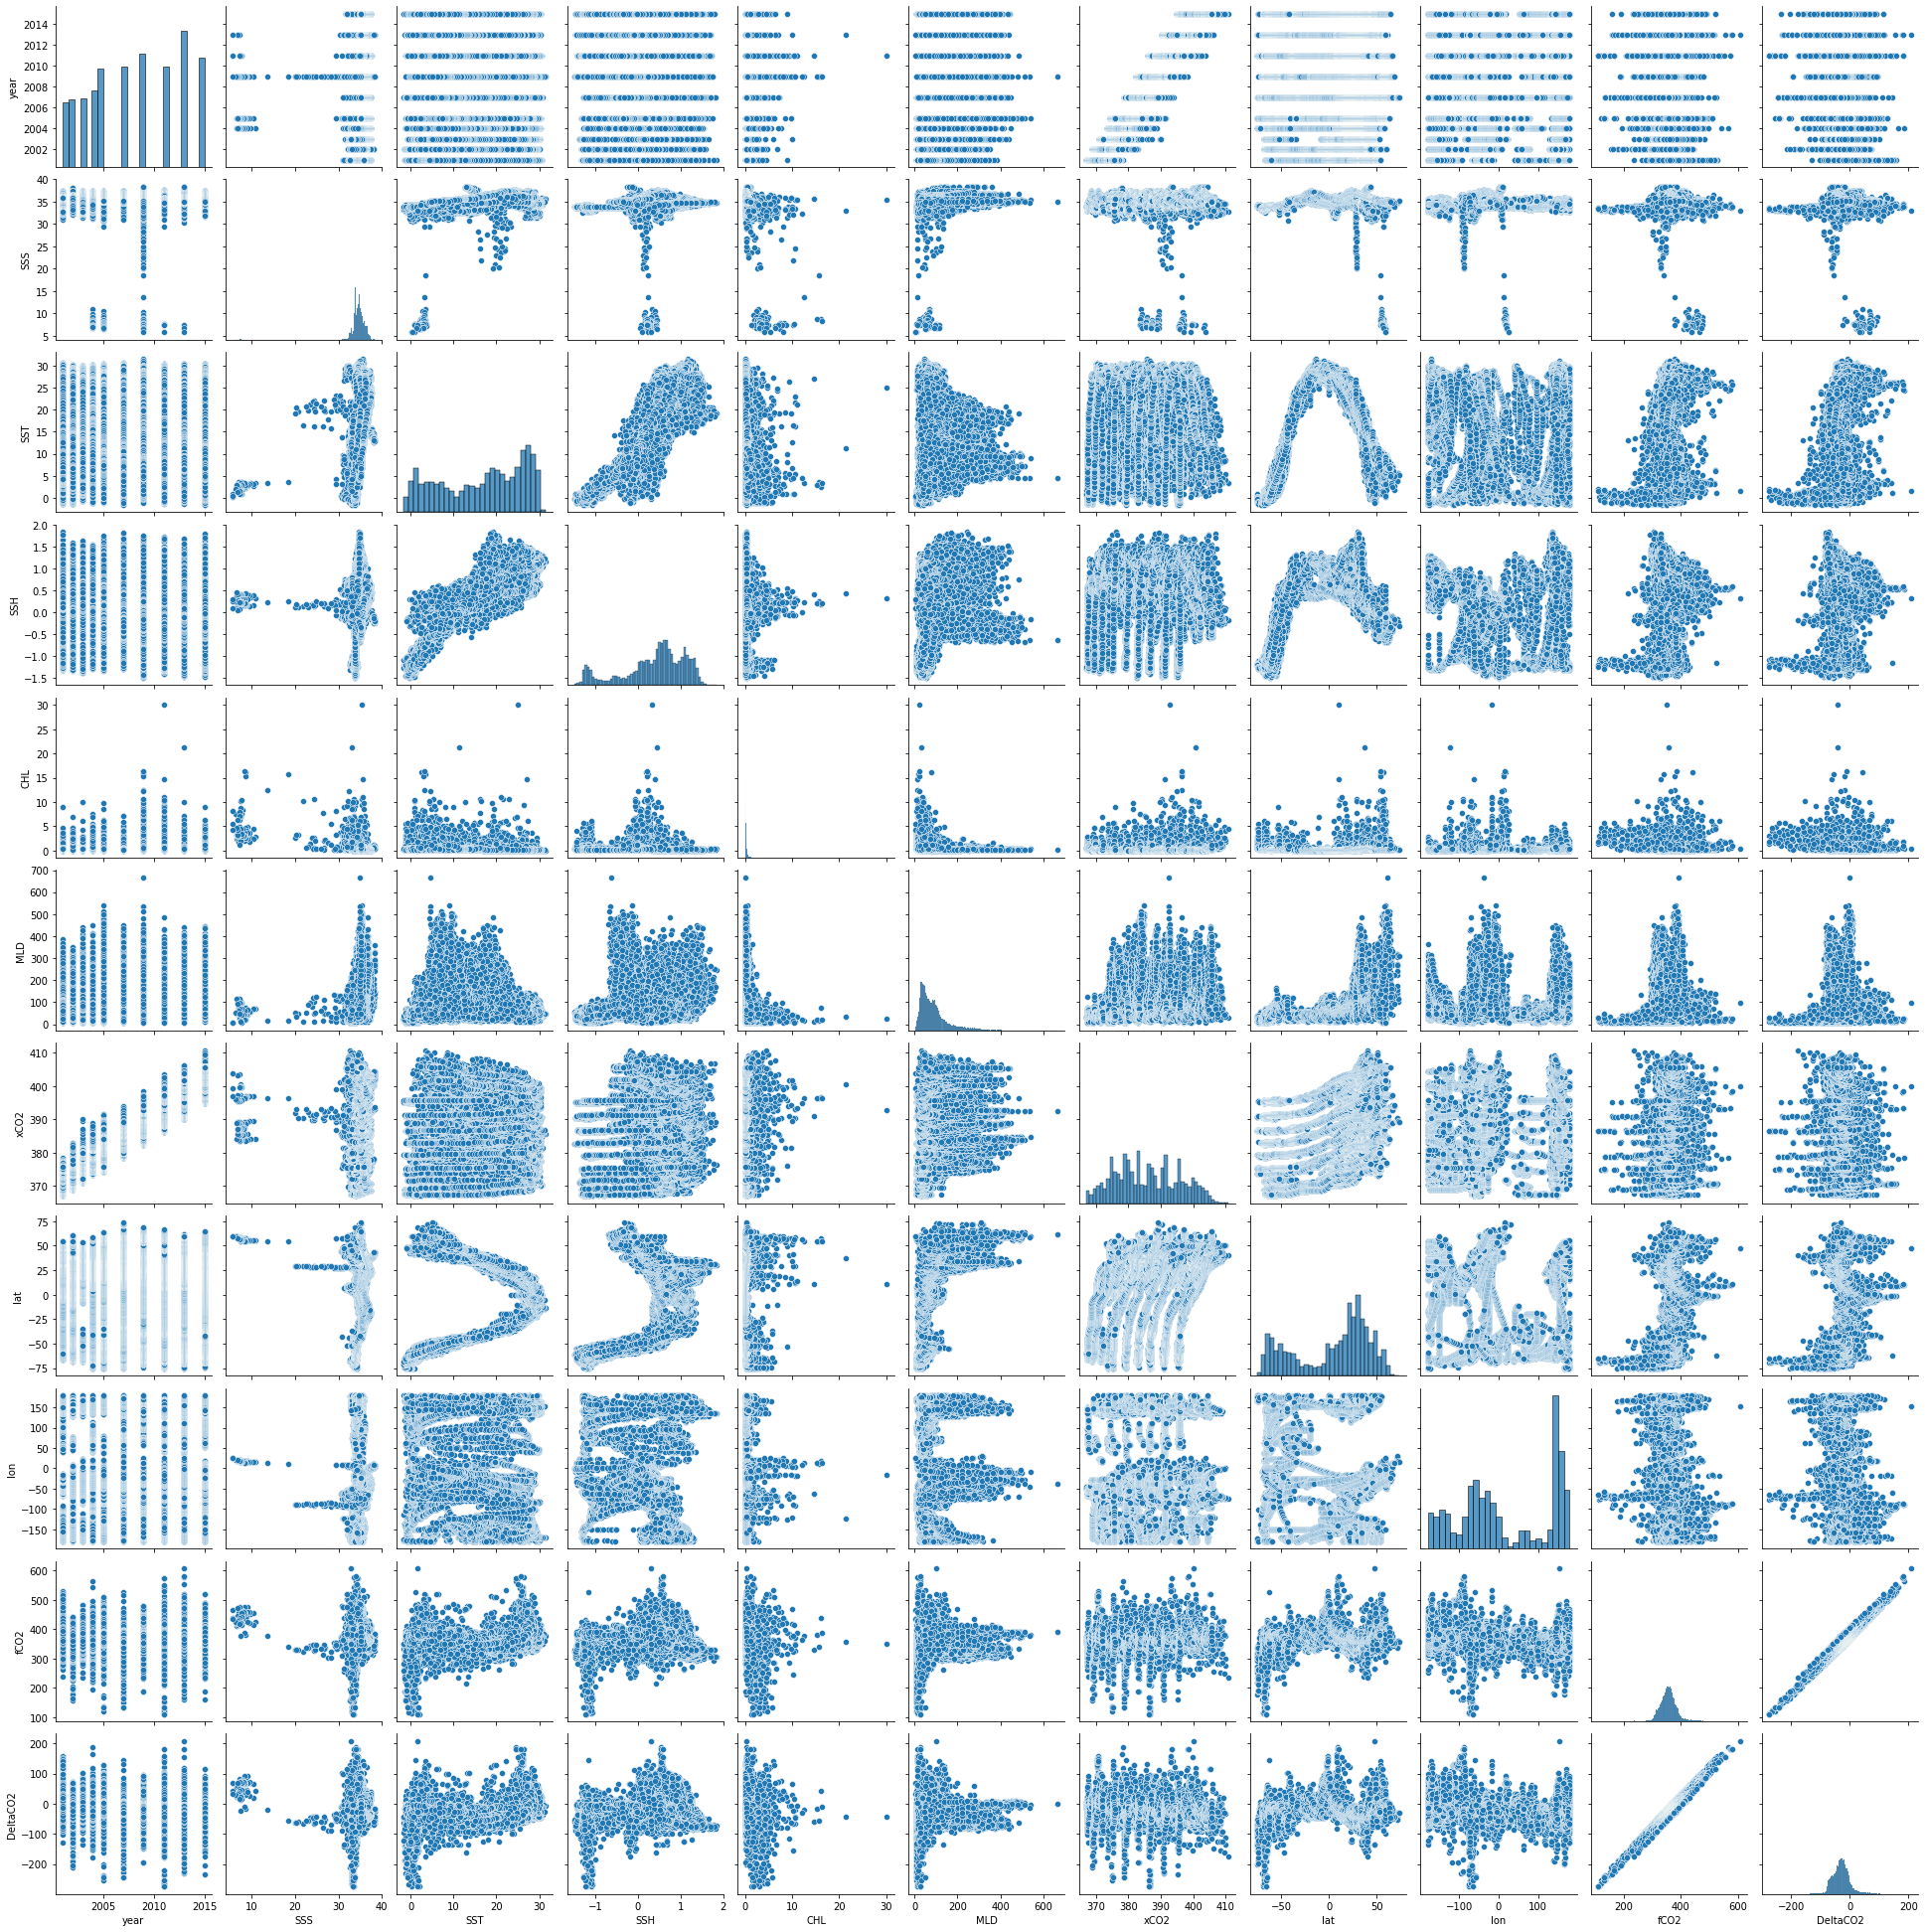

In [5]:
sns.pairplot(data)

## Baseline Solution - Linear Regression on Raw Data

In [5]:
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression().fit(predictors, target)

predictions_LR = model_LR.predict(predictors)

## Evaluation - Ocean Carbon Flux in Feb 2019

Apply your model to predict ocean-atmosphere CO<sub>2</sub> flux in Feb 2019.

A 'sensible' number for this is somewhere between -4.5 to -3.5 Pg C yr<sup>-1</sup> (1 Pg = 10<sup>15</sup> g; [Watson et al, 2020](https://www.nature.com/articles/s41467-020-18203-3)).

The lines below read in the test data (columns in the same order as training data), along with some data on surface wind speed and grid cell area used to calculate the global flux.

There are a few functions in the 'helpers' module that you might find useful for this:
 - `calc.CO2_flux` - calculate the global CO2 flux from gridded data.
 - `plot.grid` displays the prediction from the gridded data.
 - `plot.hist` displays histograms of the training and prediction data.
 - `plot.obs_vs_pred` displays the observed and predicted data on a scatterplot with a 1:1 line and some fit statistics.

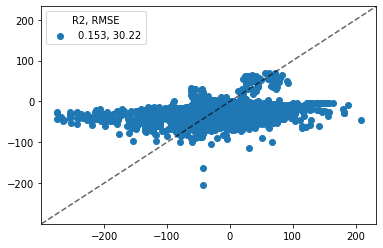

In [6]:
plot.obs_vs_pred(target, predictions_LR);

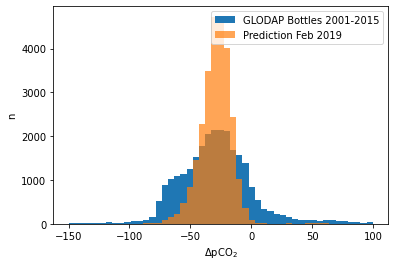

In [7]:
plot.hist(data['DeltaCO2'], predictions_LR)

### Predict global patterns

In [8]:
### gridded data for global prediction
grid_df = pd.read_csv('data/testmap.csv')

# wind and grid cell area data, used for CO2 flux calculation
grid_wind = pd.read_csv('data/wind.csv')

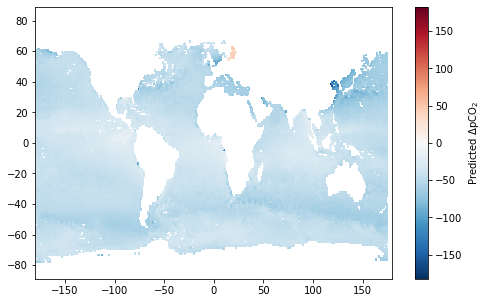

In [9]:
# apply it to global gridded parameters
pred_DeltaCO2 = model_LR.predict(grid_df)

# display the result
plot.grid(pred_DeltaCO2, grid_df)

Our initial model predicts CO2 uptake over almost the entire ocean.

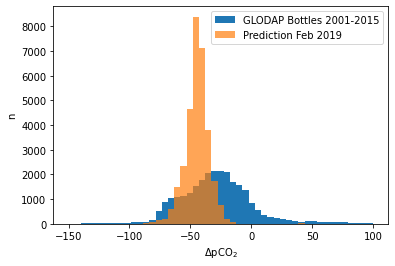

In [10]:
plot.hist(data['DeltaCO2'], pred_DeltaCO2)

The distribution of predictions is tighter and more negative than the total GLODAP bottle data.

In [12]:
calc.CO2_flux(pred_DeltaCO2, grid_wind)

-11.826105947739526

As a result, it substantially over-predicts CO<sub>2</sub> drawdown. 

## Improve this model!